In [6]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Caricamento del dataset
file_path = '../datasets/atp_tennis.csv'
data = pd.read_csv(file_path)

# Dimensioni del dataset
print(f"Dimensioni del dataset: {data.shape}")

Dimensioni del dataset: (64166, 18)


In [3]:
# Prime righe del dataset
print("Prime righe del dataset:")
print(data.head())

Prime righe del dataset:
                           Tournament    Country        Date         Series  \
0  Australian Hardcourt Championships  Australia  2000-01-03  International   
1  Australian Hardcourt Championships  Australia  2000-01-03  International   
2  Australian Hardcourt Championships  Australia  2000-01-03  International   
3  Australian Hardcourt Championships  Australia  2000-01-03  International   
4  Australian Hardcourt Championships  Australia  2000-01-03  International   

     Court Surface      Round  Best of        Player_1       Player_2  \
0  Outdoor    Hard  1st Round        3      Dosedel S.    Ljubicic I.   
1  Outdoor    Hard  1st Round        3      Clement A.     Enqvist T.   
2  Outdoor    Hard  1st Round        3       Escude N.  Baccanello P.   
3  Outdoor    Hard  1st Round        3  Knippschild J.     Federer R.   
4  Outdoor    Hard  1st Round        3     Fromberg R.  Woodbridge T.   

        Winner  Rank_1  Rank_2  Pts_1  Pts_2  Odd_1  Odd_2   

In [4]:
# Informazioni sulle colonne
print("\nInformazioni sulle colonne:")
print(data.info())


Informazioni sulle colonne:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64166 entries, 0 to 64165
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tournament  64166 non-null  object 
 1   Country     64166 non-null  object 
 2   Date        64166 non-null  object 
 3   Series      64166 non-null  object 
 4   Court       64166 non-null  object 
 5   Surface     64166 non-null  object 
 6   Round       64166 non-null  object 
 7   Best of     64166 non-null  int64  
 8   Player_1    64166 non-null  object 
 9   Player_2    64166 non-null  object 
 10  Winner      64166 non-null  object 
 11  Rank_1      64152 non-null  float64
 12  Rank_2      64154 non-null  float64
 13  Pts_1       48514 non-null  float64
 14  Pts_2       48513 non-null  float64
 15  Odd_1       60384 non-null  float64
 16  Odd_2       60386 non-null  float64
 17  Score       64166 non-null  object 
dtypes: float64(6), int64(1), object(11)
m

In [8]:
# Preparazione dei dati per il clustering

# Selezione delle colonne utili
columns_to_use = ['Tournament', 'Country', 'Series', 'Surface', 'Rank_1', 'Rank_2', 'Odd_1', 'Odd_2']
filtered_data = data[columns_to_use].copy()

# Creazione di nuove variabili: Ranking medio e Quote medie
filtered_data['Avg_Rank'] = filtered_data[['Rank_1', 'Rank_2']].mean(axis=1)
filtered_data['Avg_Odd'] = filtered_data[['Odd_1', 'Odd_2']].mean(axis=1)

# Rimozione dei valori mancanti
cleaned_data = filtered_data.dropna(subset=['Avg_Rank', 'Avg_Odd'])

# Codifica delle variabili categoriali
encoded_data = pd.get_dummies(cleaned_data, columns=['Series', 'Surface', 'Country'], drop_first=True)

# Rimozione delle colonne non necessarie per il clustering
final_data = encoded_data.drop(columns=['Tournament', 'Rank_1', 'Rank_2', 'Odd_1', 'Odd_2'])

# Dimensioni del dataset pulito
final_data_shape = final_data.shape
final_data.head(), final_data_shape

(      Avg_Rank  Avg_Odd  Series_ATP500  Series_Grand Slam  \
 2876     254.0  2.43000          False              False   
 2878      45.0  2.37500          False              False   
 2890      75.0  2.10375          False              False   
 2892     107.5  3.31500          False              False   
 2896      52.5  1.91875          False              False   
 
       Series_International  Series_International Gold  Series_Masters  \
 2876                  True                      False           False   
 2878                  True                      False           False   
 2890                  True                      False           False   
 2892                  True                      False           False   
 2896                  True                      False           False   
 
       Series_Masters 1000  Series_Masters Cup  Surface_Grass  ...  \
 2876                False               False          False  ...   
 2878                False              

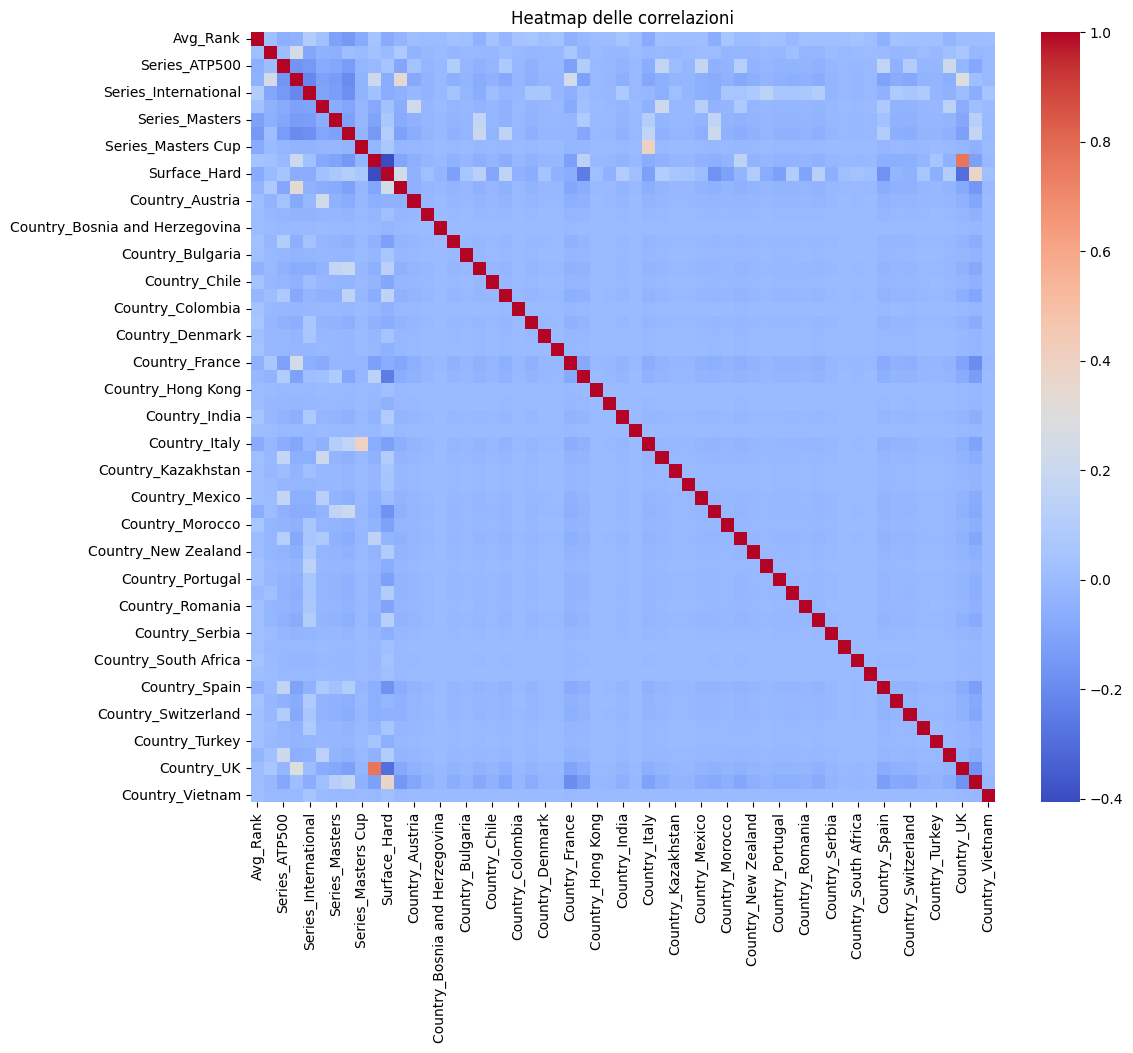

In [9]:
# Calcolo della matrice di correlazione
correlation_matrix = final_data.corr()

# Visualizzazione della heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Heatmap delle correlazioni')
plt.show()

In [10]:
# Standardizzazione dei dati
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_data)

In [11]:
# PCA: Riduzione a 2 componenti principali
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Visualizzazione della varianza spiegata
explained_variance = pca.explained_variance_ratio_
print(f"Varianza spiegata dalle prime 2 componenti: {explained_variance}")

Varianza spiegata dalle prime 2 componenti: [0.04262066 0.03342706]


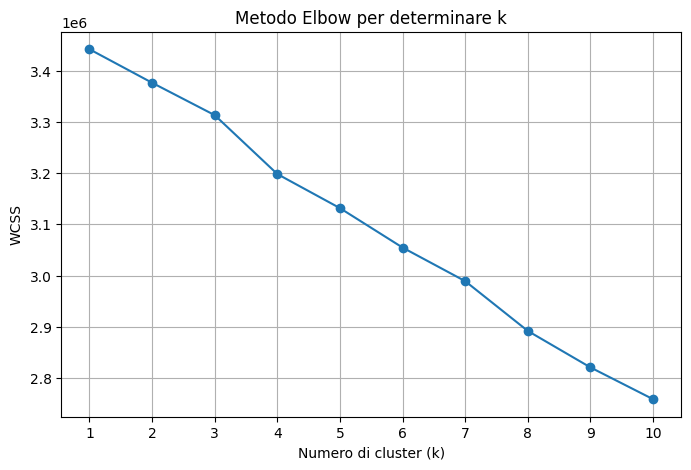

In [12]:
# Metodo Elbow
wcss = []  # Within-Cluster Sum of Squares
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Visualizzazione del metodo Elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o')
plt.title('Metodo Elbow per determinare k')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('WCSS')
plt.xticks(k_range)
plt.grid()
plt.show()

In [13]:
# Clustering con il numero ottimale di cluster
optimal_k = 4  # Cambia in base al risultato del metodo Elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Aggiunta dei cluster ai dati PCA
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

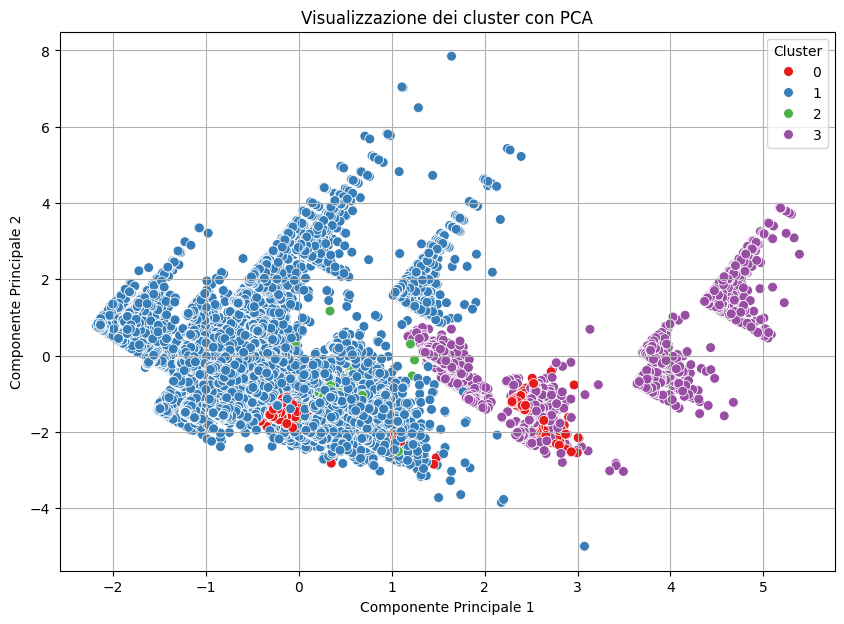

In [14]:
# Scatter plot dei cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=pca_df['PC1'],
    y=pca_df['PC2'],
    hue=pca_df['Cluster'],
    palette='Set1',
    s=50
)
plt.title('Visualizzazione dei cluster con PCA')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()